In [2]:
import gensim
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format('lemmas.sg.s100.w2v.bin', binary=True)

In [4]:
data = pd.read_csv("../../data/meediadata_cleaned1.csv")

## Build model for new data (turns out to be quite bad)

In [5]:
def get_sentence(data, s_id):
    a = list(data[data["id"] == s_id]["lemmas"])
    for i in range(len(a)):
        if pd.isnull(a[i]):
            continue
        if "|" in a[i]:
            a[i] = a[i].split("|")[0]
    return a

sentences = [get_sentence(data, i) for i in list(data["id"].drop_duplicates())]

model2 = gensim.models.Word2Vec(sentences, min_count=10)

## Make subdata with only some word types

In [6]:
def get_sonatyybid(data, s_id):
    sonad = list(data[data["id"] == s_id]["postag_descriptions"])
    a = []
    for s in sonatyybid:
        a.append(sonad.count(s))
    return a

def similarity1(s1, s2):
    score = 0
    c = 0
    for w1 in s1:
        scores = []
        for w2 in s2:
            try:
                scores.append(model.similarity(w1, w2))
            except:
                scores.append(0)
        s = max(scores)
        if s > 0:
            score += s
            c += 1
    return score / len(s1)

def sum_vectors(s, model):
    vecs = None
    count = 0
    for word in s:
        try:
            if vecs is None:
                vecs = model.word_vec(word)
            else:
                vecs.append(model.word_vec(word))
            count += 1
        except:
            continue
    if vecs is None:
        return None
    return vecs / count
    
    

def similarity2(s1, s2):
    s1_vec = sum_vectors(s1)
    s2_vec = sum_vectors(s2)
    if s1_vec is None or s2_vec is None:
        return -10
    return cosine_similarity(s1_vec, s2_vec)[0][0]

def same_words(s1, s2):
    same = len(set(s1).intersection(set(s2)))
    all = len(set(s1 + s2))
    if all == 0:
        return 0
    return same / all

def similarity3(s1_1, s1_2, s2_1, s2_2):
    p1 = similarity2(s1_1, s2_1)
    p2 = same_words(s1_2, s2_2)
    return (p1 + p2) / 2
    
    

In [10]:
vecs = pd.DataFrame(columns = [str(i) for i in range(101)])
for i in list(data["id"]):
    i = int(i)
    
    sum_vector1 = sum_vectors(get_sentence(data, i), model)
    #sum_vector2 = sum_vectors(get_sentence(data, i), model2)
    #sum_vector = get_sonatyybid(data, i)
    allikas = list(data[data["id"] == i]["allikas"])[0]
    if allikas == "err":
        a = [1]
    elif allikas == "postimees":
        a = [2]
    elif allikas == "delfi":
        a = [3]
    elif allikas == "ohtuleht":
        a = [4]
    if sum_vector1 is None:
        sum_vector1 = [-1 for i in range(100)]
    #if sum_vector2 is None:
    #    sum_vector2 = [-1 for i in range(100)]
    vecs.loc[i - 1] = list(sum_vector1) + a
    

In [11]:
vecs
vecs["allikas"] = list(data[["cleaned_pealkiri", "allikas"]].drop_duplicates()["allikas"])
vecs["id"] = list(data[["cleaned_pealkiri", "allikas", "id"]].drop_duplicates()["id"])
vecs["cleaned_pealkiri"] = list(data[["cleaned_pealkiri", "allikas"]].drop_duplicates()["cleaned_pealkiri"])
vecs["altered_pealkiri"] = list(data[["cleaned_pealkiri", "allikas", "altered_pealkiri"]].drop_duplicates()["altered_pealkiri"])
vecs.to_csv("vecs_final.csv")

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
res = pca.fit(vecs[list(range(0,100))]).transform(vecs[list(range(0,100))])

In [17]:
a = pd.DataFrame(res)
a["allikas"] = list(data[["cleaned_pealkiri", "allikas"]].drop_duplicates()["allikas"])
a["id"] = list(data[["cleaned_pealkiri", "allikas", "id"]].drop_duplicates()["id"])
a["pealkiri"] = list(data[["cleaned_pealkiri", "allikas"]].drop_duplicates()["cleaned_pealkiri"])
a["pealkiri2"] = list(data[["cleaned_pealkiri", "allikas", "altered_pealkiri"]].drop_duplicates()["altered_pealkiri"])
a.columns = ["x", "y", "allikas", "id", "pealkiri", "pealkiri2"]
c = {"err": "yellow", "postimees": "blue", "delfi": "green", "ohtuleht": "red"}
#a

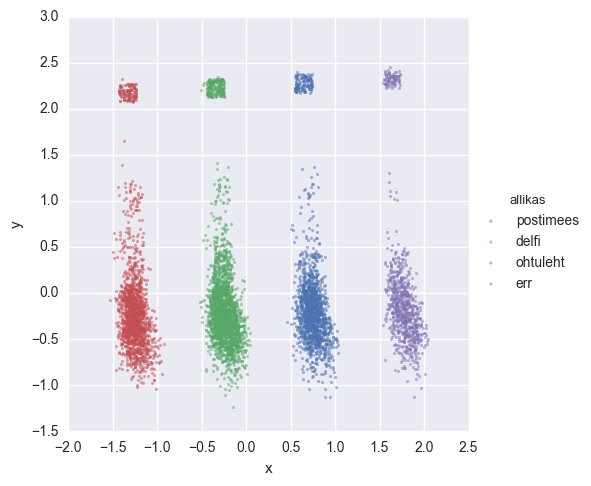

In [19]:
import seaborn as sns
sns.lmplot(x="x", y="y", hue="allikas", data=a, fit_reg=False,
           x_jitter = 0.1, y_jitter = 0.1, scatter_kws={"s": 5, "alpha": 0.5})

In [ ]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from random import random
output_file("toolbar.html")

source = ColumnDataSource(
        data=dict(
            x=[x + (-0.2 + random() * 0.4) for x in list(a["x"])],
            y=[y + (-0.2 + random() * 0.4) for y in list(a["y"])],
            desc=list(a["allikas"]),
            pealkiri2=list(a["pealkiri2"]),
            color=[c[x] for x in a["allikas"]],
        )
    )

hover = HoverTool(
        tooltips=[
            ("desc", "@desc"),
            ("pealkiri2", "@pealkiri2"),
            ("(x,y)", "($x, $y)"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=2, source=source, color="color", fill_alpha = 0.2, line_alpha = 0.2)

show(p)